<a href="https://colab.research.google.com/github/Abdulaziz1607/NATIXIS-CHALLENGE/blob/main/Natixis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---



# ENS Challenge: Natixis

---



# Bibli

In [ ]:
import pandas as pd, seaborn as sns, numpy as np, matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Importer les données


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
%cd drive/My Drive/Colab Notebooks/Natixis
X_train = pd.read_csv('X_train.csv',sep=',')
X_test = pd.read_csv('X_test.csv',sep=',')
Y_train = pd.read_csv('Y_train.csv',sep=',')

/content/drive/My Drive/Colab Notebooks/Natixis


# Métrique


In [ ]:
import numpy as np
import pandas as pd
from django.shortcuts import get_object_or_404


def PreparationScore(datasetValidation, reducedsoumissionDelta, nbscenarios):
    nbDates = 261
    S = np.zeros((nbscenarios, nbDates))
    vanillePrice = np.zeros((nbscenarios, nbDates))
    vanilleDelta = np.zeros((nbscenarios, nbDates))
    vanilleVega = np.zeros((nbscenarios, nbDates))
    autocallDelta = np.zeros((nbscenarios, nbDates))
    autocallVega = np.zeros((nbscenarios, nbDates))

    S[:, :] = datasetValidation[:, :nbDates]
    vanillePrice[:, :] = datasetValidation[:, 6*nbDates:7*nbDates]
    vanilleDelta[:, :] = datasetValidation[:, 7*nbDates:8*nbDates]
    vanilleVega[:, :] = datasetValidation[:, 8*nbDates:9*nbDates]
    autocallDelta[:, :] = datasetValidation[:, 4*nbDates:5*nbDates]
    autocallVega[:, :] = datasetValidation[:, 5*nbDates:6*nbDates]

    Barrier = 1
    nb0Vanille = np.zeros((nbscenarios))
    nb1Vanille = np.zeros((nbscenarios))
    nb0Vanille[:] = autocallVega[:, 0] / vanilleVega[:, 0]
    AutocallVegaCorrected130 = autocallVega[:, 130] - nb0Vanille[:] * vanilleVega[:, 130]
    mask_below_barrier = S[:, 130] < Barrier
    nb1Vanille[mask_below_barrier] = AutocallVegaCorrected130[mask_below_barrier] / vanilleVega[mask_below_barrier, 130]
    return reducedsoumissionDelta, autocallDelta, autocallVega, vanilleDelta, vanilleVega, nb0Vanille, nb1Vanille, vanillePrice, S


def ControlLimits(soumissionDelta, autocallDelta, autocallVega, vanilleDelta, vanilleVega, nb0Vanille, nb1Vanille, nbscenarios,lim):
    LimitRespected = True
    limites = lim
    epsilon = 0.001
    nblim = len(lim)
    nbDates = 261
    AutocallVegaCorrected = np.zeros((nbscenarios, nbDates))
    TotalDelta = np.zeros((nbscenarios, nbDates))
    reshaped_nb0Vanille = nb0Vanille.reshape((nbscenarios, 1))
    reshaped_nb1Vanille = nb1Vanille.reshape((nbscenarios, 1))
    TotalDelta[:, :131] = autocallDelta[:, :131] - reshaped_nb0Vanille * vanilleDelta[:, :131]
    for iLimit in range(nblim):
        print("max:",np.max(abs(soumissionDelta[:, iLimit * nbDates:iLimit * nbDates + 131] + TotalDelta[:, :131])))
        if (abs(soumissionDelta[:, iLimit * nbDates:iLimit * nbDates + 131] + TotalDelta[:, :131]) > (limites[iLimit] + epsilon)).any():
            LimitRespected = False
    print("OK ")
    TotalDelta[:, 131:nbDates] = autocallDelta[:, 131:nbDates] - (reshaped_nb0Vanille + reshaped_nb1Vanille) * vanilleDelta[:, 131:nbDates]
    for iLimit in range(nblim):
        print("max:",np.max(abs(soumissionDelta[:, 131 + iLimit * nbDates:nbDates + iLimit * nbDates] + TotalDelta[:, 131:nbDates])))
        if (abs(soumissionDelta[:, 131 + iLimit * nbDates:nbDates + iLimit * nbDates] + TotalDelta[:, 131:nbDates]) > limites[iLimit] + epsilon).any():
            LimitRespected = False
    return LimitRespected


def CalculScore(soumissionDelta, nb0Vanille, nb1Vanille, vanillePrice, S, nbscenarios,lim):
    CDelta = 0.0001
    CVega = 0.02
    nbDates = 261
    Barrier = 1
    strike = 1
    rebate = 0.05
    nblim = len(lim)
    payoff = np.zeros((nbscenarios))
    hedgeBenefit = np.zeros((nblim, nbscenarios))
    vegahedgePayoff = np.zeros((nblim, nbscenarios))
    transacDeltaCost = np.zeros((nblim, nbscenarios))
    transacVegaCost = np.zeros((nblim, nbscenarios))
    achatsDeltaCost = np.zeros((nblim, nbscenarios))
    AutocallFlag = np.zeros((nbscenarios))

    mask_S_below_barrier = S[:, 130] <= Barrier
    payoff[mask_S_below_barrier] = np.maximum(S[mask_S_below_barrier, 260] - strike, 0)
    AutocallFlag[mask_S_below_barrier] = 1
    payoff[~mask_S_below_barrier] = rebate
    AutocallFlag[~mask_S_below_barrier] = 0

    price = np.zeros((nblim))
    for iLimit in range(nblim):
        # determination des hedge limites
        # calcul du pay-off de l'equinoxe

        # calcul du cout de hedge
        hedgeBenefit[iLimit, :] += np.sum(soumissionDelta[:, iLimit * nbDates:iLimit * nbDates + 131] * (S[:, 1:132] - S[:, :131]), axis=1)
        for idate in range(131):
            # calcul du delta acheté
            if (idate == 0):
                achatDelta = soumissionDelta[:, idate + iLimit * nbDates]
            else:
                achatDelta = (soumissionDelta[:, idate + iLimit * nbDates] - soumissionDelta[:,
                                                                             idate + iLimit * nbDates - 1])
            # calcul impact tresorerie des achat de delta
            achatsDeltaCost[iLimit, :] += achatDelta * S[:, idate]
            # calcul des couts de transactions en delta
            transacDeltaCost[iLimit, :] += abs(achatsDeltaCost[iLimit, :])

        hedgeBenefit[iLimit, :] += np.sum(AutocallFlag[:].reshape(nbscenarios,1) * soumissionDelta[:, 131 + iLimit * nbDates:(nbDates-1) + iLimit * nbDates] * (S[:, 132:nbDates] - S[:, 131:nbDates-1]), axis=1)
        for idate in range(131, nbDates - 1):
            # calcul du delta acheté
            if (idate == 0):
                achatDelta = soumissionDelta[:, idate + iLimit * nbDates]
            else:
                achatDelta = (soumissionDelta[:, idate + iLimit * nbDates] - soumissionDelta[:,
                                                                             idate + iLimit * nbDates - 1])
            # calcul impact tresorerie des achat de delta
            achatsDeltaCost[iLimit, :] += achatDelta * S[:, idate]
            # calcul des couts de transactions en delta
            transacDeltaCost[iLimit, :] += AutocallFlag[:] * abs(achatsDeltaCost[iLimit, :])

        # calcul du payoff du au vegahedge
        vegahedgePayoff[iLimit, :] = \
            (nb0Vanille[:] + nb1Vanille[:]) * np.maximum(S[:, 260] - strike, 0) * AutocallFlag[:] \
            + nb0Vanille[:] * np.maximum(S[:, 260] - strike, 0) * (1 - AutocallFlag[:]) \
            - nb0Vanille[:] * vanillePrice[:, 0] - nb1Vanille[:] * vanillePrice[:, 130]
        # calcul du cout des transactions en vega
        transacVegaCost[iLimit, :] = (abs(nb0Vanille[:] * vanillePrice[:, 0]) + abs(nb1Vanille[:])) * vanillePrice[:,130]
        # calcul de l'utility function traduite en prix (pris dans
        # Deep Hedging Swissquote Conference 2018 on Machine Learning in Finance Geneva, Nov 9th 2018 by Dr. Hans Buehler, adapté au vega hedge)
        price[iLimit] = np.log(
            np.mean(
                np.exp(
                    -(hedgeBenefit[iLimit, :] - payoff[:] + vegahedgePayoff[iLimit, :]
                      - transacDeltaCost[iLimit, :] * CDelta - transacVegaCost[iLimit, :] * CVega)
                )
            )
        )
    score = np.mean(price)
    all_ =  -(hedgeBenefit[iLimit, :] - payoff[:] + vegahedgePayoff[iLimit, :]- transacDeltaCost[iLimit, :] * CDelta - transacVegaCost[iLimit, :] * CVega)
    return score,all_


def scoring(reducedsoumissionDelta, datasetValidation, nbscenarios,lim):
    reducedsoumissionDelta, autocallDelta, autocallVega, vanilleDelta, vanilleVega, nb0Vanille, nb1Vanille, vanillePrice, S = PreparationScore(
        datasetValidation, reducedsoumissionDelta, nbscenarios)
    if ControlLimits(reducedsoumissionDelta, autocallDelta, autocallVega, vanilleDelta, vanilleVega, nb0Vanille,
                     nb1Vanille, nbscenarios,lim):
        score = CalculScore(reducedsoumissionDelta, nb0Vanille, nb1Vanille, vanillePrice, S, nbscenarios,lim)
    else:
        score = 100000
    return score


def scoringFromDataFrame(Validation,submissiondataframe,lim):
    validationdataframe = Validation
    reducedsoumissionDelta = submissiondataframe.values
    index_traj = submissiondataframe.index.values
    nbscenarios = len(index_traj)
    XdatasetValidation = validationdataframe.iloc[index_traj].values[0:, 0:]
    score = scoring(reducedsoumissionDelta, XdatasetValidation, nbscenarios,lim)
    return score

# Analyser les données

In [ ]:
X_test.drop(['ID'],axis=1,inplace=True)
X_train.drop(['ID'],axis=1,inplace=True)
Y_train.drop(['ID'],axis=1,inplace=True)

In [ ]:
index_traj =X_test.index.values
nbDates = 261
nbscenarios = len(index_traj)
datasetValidation = X_test.iloc[index_traj].values[0:, 0:]
S = np.zeros((nbscenarios, nbDates))

In [ ]:
S = np.zeros((nbscenarios, nbDates))
X = np.zeros((nbscenarios, nbDates))
vanillePrice = np.zeros((nbscenarios, nbDates))
vanilleDelta = np.zeros((nbscenarios, nbDates))
vanilleVega = np.zeros((nbscenarios, nbDates))
autocallDelta = np.zeros((nbscenarios, nbDates))
autocallVega = np.zeros((nbscenarios, nbDates))

S[:, :] = datasetValidation[:, :nbDates]
X[:,:] = datasetValidation[:, 3*nbDates:4*nbDates]
vanillePrice[:, :] = datasetValidation[:, 6*nbDates:7*nbDates]
vanilleDelta[:, :] = datasetValidation[:, 7*nbDates:8*nbDates]
vanilleVega[:, :] = datasetValidation[:, 8*nbDates:9*nbDates]
autocallDelta[:, :] = datasetValidation[:, 4*nbDates:5*nbDates]
autocallVega[:, :] = datasetValidation[:, 5*nbDates:6*nbDates]
Barrier = 1
nb0Vanille = np.zeros((nbscenarios))
nb1Vanille = np.zeros((nbscenarios))
nb0Vanille[:] = autocallVega[:, 0] / vanilleVega[:, 0]
AutocallVegaCorrected130 = autocallVega[:, 130] - nb0Vanille[:] * vanilleVega[:, 130]
mask_below_barrier = S[:, 130] < Barrier
nb1Vanille[mask_below_barrier] = AutocallVegaCorrected130[mask_below_barrier] / vanilleVega[mask_below_barrier, 130]


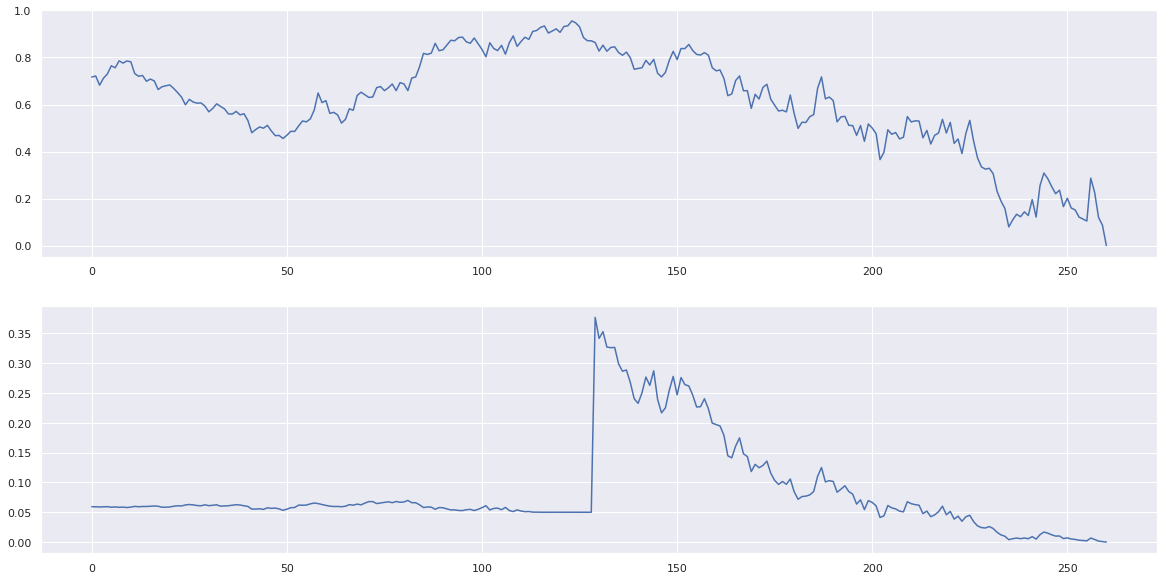

In [ ]:
n = 3000
fig,ax = plt.subplots(ncols=1,nrows=2,figsize=(20,10))
ax[0].plot(np.arange(0,261),vanilleDelta[n,:]),
ax[1].plot(np.arange(0,261),X[n,:]);

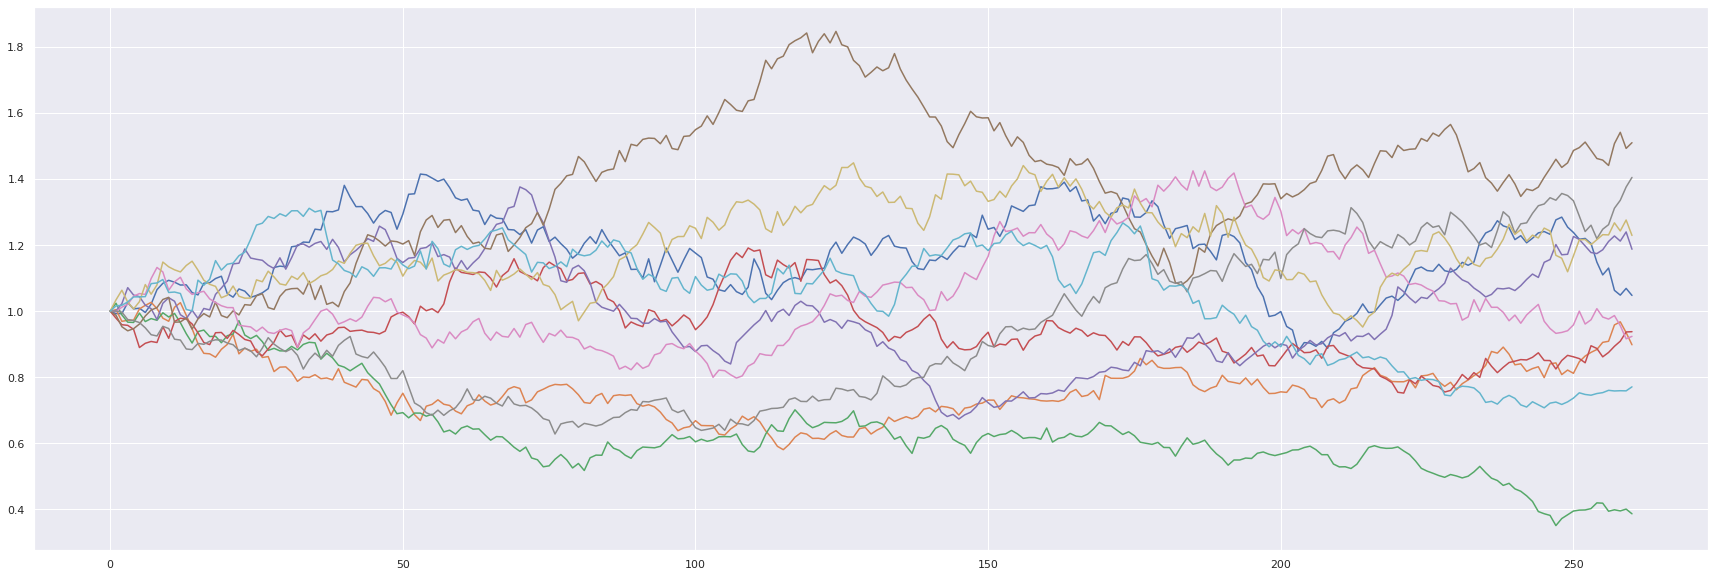

In [ ]:
fig,ax = plt.subplots(figsize=(30,10))
for i in range(20,30):
   plt.plot(S[i,:])
plt.show()

# Deep Hedging

In [ ]:
import numpy as np
import tensorflow as tf

from keras.models import Sequential
from keras.layers import LSTM,Input, Dense, Conv2D, Concatenate, Dropout, Subtract, \
                        Flatten, MaxPooling2D, Multiply, Lambda, Add, Dot,Minimum
from keras.backend import constant
from keras import optimizers

from keras.engine.topology import Layer
from keras.models import Model
from keras.layers import Input
from keras import initializers
from keras.constraints import max_norm
import keras.backend as K
from keras import regularizers

Using TensorFlow backend.


## Modele de réseaux de neurones pour chaque limite

### 1

In [ ]:
N =  261 # Nombre de semaines
m = 1 # dimension of hedge
d = 3 # number of layers in strategy
n = 10  # nodes in the first but last layers

layers = []
for j in range(N-1):
    for i in range(d):
        if i < d-1:
            nodes = n
            layer = Dense(nodes, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                      bias_initializer='random_normal',
                      name=str(i)+str(j))
        else:
            nodes = m
            layer = Dense(nodes, activation='tanh', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        layers = layers + [layer]

inputs = []
hedge = Input(shape=(m,))
CDelta = Input(shape=(m,))
transDeltaCost = Input(shape=(m,))
payoff = Input(shape=(m,))
autocallflag  = Input(shape=(m,)) 
transvegaCost = Input(shape=(m,)) 
payoffVega = Input(shape=(m,))
lastDelta = Input(shape=(m,))

for i in range(N):
  inputs = inputs + [Input(shape=(m,))]

inputsall = inputs+[hedge]+[payoff]+[transvegaCost]+[transDeltaCost]+[payoffVega]+[CDelta]+[lastDelta]+[autocallflag]
#-------------------------------------------------------------------------------------------------------------------------------#

delta_opt=[]

for j in range(N):
  
    if j < N-1 :
      
      if j < 131 :     

        if j == 0 :

          strategy_k =  inputs[j]
          for k in range(d):
            strategy_k= layers[k+j*d](strategy_k)
          strategy_k_1 = strategy_k
          delta_opt = delta_opt + [strategy_k]

        else : 
          strategy_k =  inputs[j]
          for k in range(d):
            strategy_k= layers[k+j*d](strategy_k)
    
          pricenew=inputs[j+1]
          priceincr=Subtract()([pricenew, inputs[j]])
          hedgenew = Multiply()([strategy_k_1, priceincr])
          hedge = Add()([hedge,hedgenew])

          achatDelta = Subtract()([strategy_k,strategy_k_1])                     
          achatDeltaCost = Multiply()([achatDelta,inputs[j]])
          achatDeltaCost = Lambda(lambda x : K.abs(x))(achatDeltaCost)
          transDeltaCost = Add()([transDeltaCost,achatDeltaCost])
          delta_opt = delta_opt + [strategy_k]
    
          strategy_k_1 = strategy_k

      else :
        strategy_k =  inputs[j]
        for k in range(d):
          strategy_k= layers[k+j*d](strategy_k)
    
        pricenew=inputs[j+1]
        priceincr=Subtract()([pricenew, inputs[j]])
        hedgenew = Multiply()([strategy_k_1, priceincr])
        hedgenew = Multiply()([autocallflag,hedgenew])
        hedge = Add()([hedge,hedgenew])

        achatDelta = Subtract()([strategy_k,strategy_k_1])                     
        achatDeltaCost = Multiply()([achatDelta,inputs[j]])
        achatDeltaCost = Lambda(lambda x : K.abs(x))(achatDeltaCost)
        achatDeltaCost = Multiply()([autocallflag, achatDeltaCost])
        transDeltaCost = Add()([transDeltaCost,achatDeltaCost])
        delta_opt = delta_opt + [strategy_k]
    
        strategy_k_1 = strategy_k
    else :
      achatDelta = Subtract()([lastDelta,strategy_k_1])                     
      achatDeltaCost = Multiply()([achatDelta,inputs[j]])
      achatDeltaCost = Lambda(lambda x : K.abs(x))(achatDeltaCost)
      transDeltaCost = Add()([transDeltaCost,achatDeltaCost])
      delta_opt = delta_opt + [strategy_k]


outputs = Subtract()([payoff,hedge]) 
outputs = Subtract()([outputs,payoffVega])
outputs = Add()([outputs,transvegaCost])
transDeltaCost = Multiply()([transDeltaCost,CDelta])
outputs = Add()([outputs,transDeltaCost])
outputs= [outputs] + delta_opt 
outputs= Concatenate()(outputs)
model_hedge = Model(inputs=inputsall, outputs=[outputs,outputs])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Variables inputs

In [ ]:
CDelta = 0.0001*np.ones((nbscenarios,))
CVega = 0.02
nbDates = 261
Barrier = 1
strike = 1
rebate = 0.05
nbscenarios = 5000
hedge = np.zeros((nbscenarios,))
payoff = np.zeros((nbscenarios,))
payoffVega = np.zeros((nbscenarios,))
achatsDeltaCost = np.zeros((nbscenarios,))
transacDeltaCost = np.zeros((nbscenarios,))
transacVegaCost = np.zeros((nbscenarios,))
autocallFlag = np.zeros((nbscenarios,))
autocallFlag_inv = np.zeros((nbscenarios,))

TotalDelta = np.zeros((nbscenarios, nbDates))
reshaped_nb0Vanille = nb0Vanille.reshape((nbscenarios, 1))
reshaped_nb1Vanille = nb1Vanille.reshape((nbscenarios, 1))
TotalDelta[:, :131] = autocallDelta[:, :131] - reshaped_nb0Vanille * vanilleDelta[:, :131]
TotalDelta[:, 131:nbDates] = autocallDelta[:, 131:nbDates] - (reshaped_nb0Vanille + reshaped_nb1Vanille) * vanilleDelta[:, 131:nbDates]

mask_S_below_barrier = S[:, 130] <= Barrier
payoff[mask_S_below_barrier] = np.maximum(S[mask_S_below_barrier, 260] - strike, 0)
autocallFlag[mask_S_below_barrier] = 1
payoff[~mask_S_below_barrier] = rebate
autocallFlag[~mask_S_below_barrier] = 0

px = Input(shape=(32,))
y = Dense(16, activation='softmax')(x)

payoffVega[:] = (nb0Vanille[:] + nb1Vanille[:]) * np.maximum(S[:, 260] - strike, 0) * autocallFlag[:] + nb0Vanille[:] * np.maximum(S[:, 260] - strike, 0) * (1 - autocallFlag[:]) - nb0Vanille[:] * vanillePrice[:, 0] - nb1Vanille[:] * vanillePrice[:, 130]

transacVegaCost[:] = (abs(nb0Vanille[:] * vanillePrice[:, 0]) + abs(nb1Vanille[:]) * vanillePrice[:,130])*0.001


In [ ]:
from keras import losses
def custom_loss(y_true,y_pred):
    
    z = y_true[:,0]-y_pred[:,0]
    z=K.log(K.mean(K.exp(-z))) 
    return z

def custom_loss_2(y_true,y_pred):

    return losses.mean_absolute_error(y_true[:,1:],y_pred[:,1:])

## Analyse Inputs

en dessous de la barriere : 0.0  ( 1 si S_130 < 1 sinon 0) 


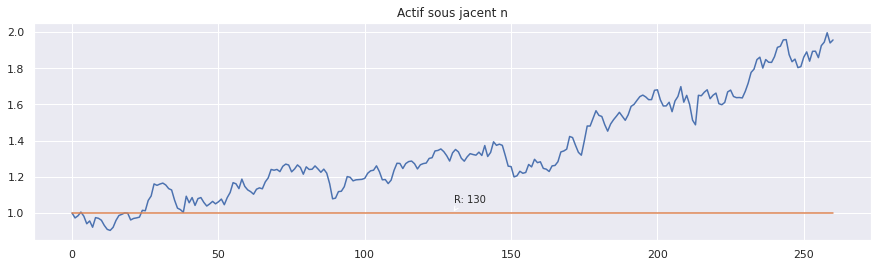

In [ ]:
# 0 -> 3049
# 1 -> 1234
n=901
print("en dessous de la barriere : {}  ( 1 si S_130 < 1 sinon 0) ".format(autocallFlag[n]))
fig,ax = plt.subplots(figsize=(15,4))
ax.plot(np.arange(0,261),S[n,:261]);
plt.plot(np.arange(0,261),np.ones((261)))
plt.annotate("R: 130",
         xy=(130, 1), xycoords='data',
         xytext=(+1, +10), textcoords='offset points', fontsize=10,
         arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
ax.set_title("Actif sous jacent n");

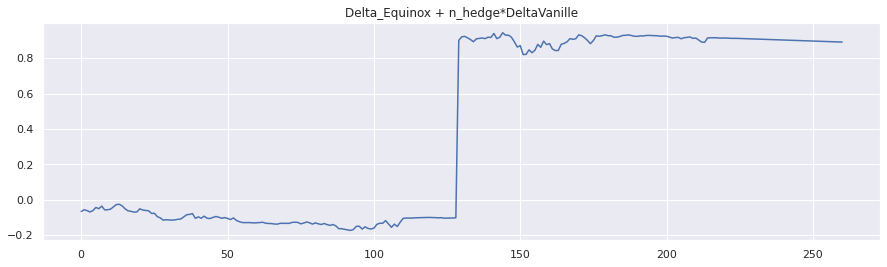

In [ ]:
fig,ax = plt.subplots(figsize=(15,4))
ax.plot(np.arange(0,261),TotalDelta[n,:261]);
ax.set_title("Delta_Equinox + n_hedge*DeltaVanille");

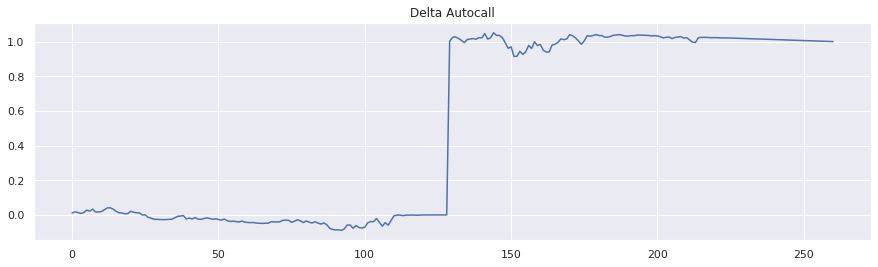

In [ ]:
fig,ax = plt.subplots(figsize=(15,4))
ax.plot(np.arange(0,261),autocallDelta[n,:]);
ax.set_title("Delta Autocall");

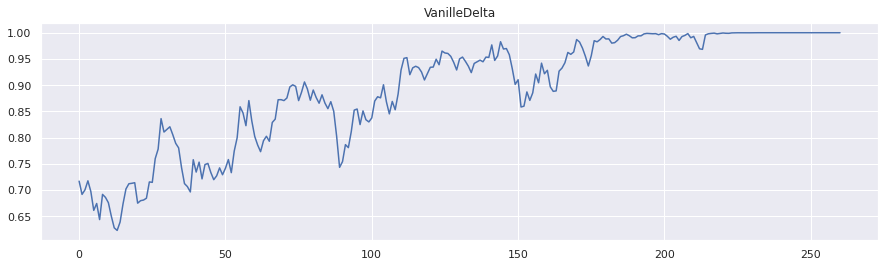

In [ ]:
fig,ax = plt.subplots(figsize=(15,4))
ax.plot(np.arange(0,261),vanilleDelta[n,:]);
ax.set_title("VanilleDelta");

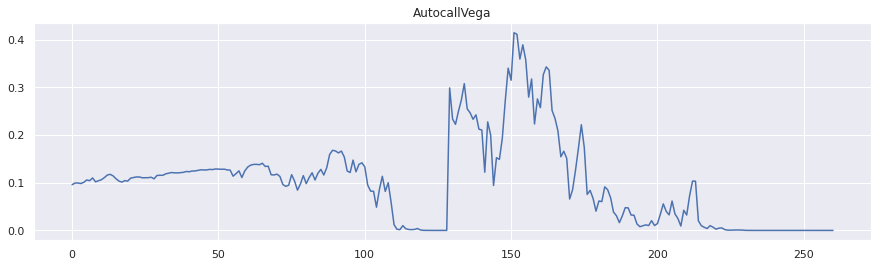

In [ ]:
fig,ax = plt.subplots(figsize=(15,4))
ax.plot(np.arange(0,261),autocallVega[n,:]);
ax.set_title("AutocallVega");

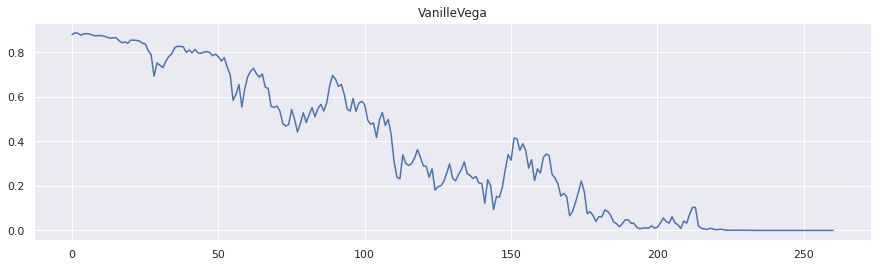

In [ ]:
fig,ax = plt.subplots(figsize=(15,4))
ax.plot(np.arange(0,261),vanilleVega[n,:]);
ax.set_title("VanilleVega");

In [ ]:
print(nb0Vanille[n])
print(nb1Vanille[n])
print(nb1Vanille[n]+nb0Vanille[n])

0.10900827930810753
0.0
0.10900827930810753


In [ ]:
print("payoff :",np.max([S[n,260]-Barrier,0]))

payoff : 0.95575231


In [ ]:
score, all_  = scoringFromDataFrame(X_test,pd.DataFrame(TotalDelta*-1),[0.1])
all_[all_ < 0.06].shape

max: 0.0
OK 
max: 0.0


(2462,)

In [ ]:
score, all_  = scoringFromDataFrame(X_test,pd.DataFrame(TotalDelta*-1),[0.2])
score

max: 0.0
OK 
max: 0.0


0.07820232796714596

In [ ]:
 resume = pd.concat([pd.DataFrame(all_),pd.DataFrame(autocallFlag)],axis=1)
 resume.columns = ("CR","sous_B")

moyenne CR pour autocallFlag == 0 0.03483329471097861
STD CR pour autocallFlag == 0 0.06451784197911314


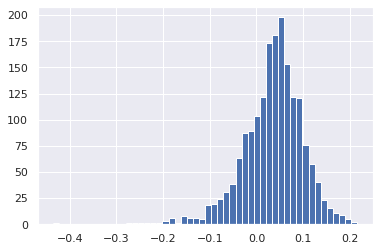

In [ ]:
print("moyenne CR pour autocallFlag == 0",resume[resume["sous_B"]==0]["CR"].mean())
print("STD CR pour autocallFlag == 0",resume[resume["sous_B"]==0]["CR"].std())
plt.hist(resume[resume["sous_B"]==0]["CR"],bins=50);

nmoyenne CR pour autocallFlag == 1 0.09837314973673185
Std CR pour autocallFlag == 1 0.0751235939106365


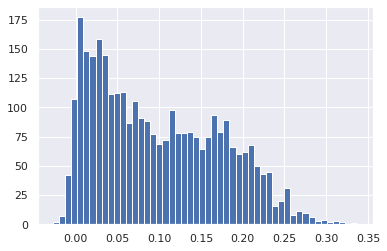

In [ ]:
print("nmoyenne CR pour autocallFlag == 1",resume[resume["sous_B"]==1]["CR"].mean())
print("Std CR pour autocallFlag == 1",resume[resume["sous_B"]==1]["CR"].std())
plt.hist(resume[resume["sous_B"]==1]["CR"],bins=50);

utility fonction  0.0751683946813269


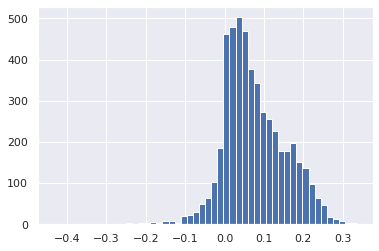

In [ ]:
print("utility fonction ",resume["CR"].mean())
plt.hist(resume["CR"],bins=50);

# Prediction

## Prediction L = 0.1

In [ ]:
# y_train_delta = -1*TotalDelta

In [ ]:
#loss_weights=[0.3,0.7]
lim = 0.1*np.ones((nbscenarios,))
ytrain =np.concatenate((-0.5*np.ones((5000,m)),-1*TotalDelta),axis=1)
inputs = (S_1 + TotalDelta_1 + [hedge] + [payoff]+ [Delta0]+[transacVegaCost]+[transacDeltaCost]+[payoffVega]+[CDelta]+[autocallFlag_inv]+[lim])
model_hedge.compile(optimizer='adam',loss=[custom_loss,custom_loss_2],loss_weights=[1.5,1])
model_hedge.fit(x=inputs,y=[ytrain,ytrain], epochs=15,verbose=True)

delta_array = model_hedge.predict(inputs)
predict_1 = delta_array[0]
predict_2 = delta_array[1]
predict = predict_1
print("moyenne CR :",np.mean(predict[:,0]))
print("STD CR :",np.std(predict[:,0]))
plt.hist(predict[:,0],bins=50);
y=np.log(np.mean(np.exp(predict[:,0])))
print("CR",y)

##  Prediction L = 0.2

In [ ]:
#loss_weights=[0.3,0.7]
lim = 0.2*np.ones((nbscenarios,))
ytrain =np.concatenate((-0.5*np.ones((5000,m)),-1*TotalDelta),axis=1)
inputs = (S_1 + TotalDelta_1 + [hedge] + [payoff]+ [Delta0]+[transacVegaCost]+[transacDeltaCost]+[payoffVega]+[CDelta]+[autocallFlag_inv]+[lim])
model_hedge2.compile(optimizer='adam',loss=[custom_loss,custom_loss_2],loss_weights=[1.5,1])
model_hedge2.fit(x=inputs,y=[ytrain,ytrain], epochs=15,verbose=True)

delta_array2 = model_hedge2.predict(inputs)
predict_1 = delta_array2[0]
predict_2 = delta_array2[1]
predict = predict_1
print("moyenne CR :",np.mean(predict[:,0]))
print("STD CR :",np.std(predict[:,0]))
plt.hist(predict[:,0],bins=50);
y=np.log(np.mean(np.exp(predict[:,0])))
print("CR",y)

## Prediction L = 0.5

In [ ]:
#loss_weights=[0.3,0.7]
lim = 0.5*np.ones((nbscenarios,))
ytrain =np.concatenate((-0.5*np.ones((5000,m)),-1*TotalDelta),axis=1)
inputs = (S_1 + TotalDelta_1 + [hedge] + [payoff]+ [Delta0]+[transacVegaCost]+[transacDeltaCost]+[payoffVega]+[CDelta]+[autocallFlag_inv]+[lim])
model_hedge3.compile(optimizer='adam',loss=[custom_loss,custom_loss_2],loss_weights=[1.5,1])
model_hedge3.fit(x=inputs,y=[ytrain,ytrain], epochs=15,verbose=True)

delta_array3 = model_hedge3.predict(inputs)
predict_1 = delta_array3[0]
predict_2 = delta_array3[1]
predict = predict_1
print("moyenne CR :",np.mean(predict[:,0]))
print("STD CR :",np.std(predict[:,0]))
plt.hist(predict[:,0],bins=50);
y=np.log(np.mean(np.exp(predict[:,0])))
print("CR",y)

# Submission

In [ ]:
predi = pd.DataFrame(-1*TotalDelta)

In [ ]:
submission = pd.concat([delta_array,delta_array2,delta_array3],axis=1)
submission.columns = list(Y_train.columns.values)
submission.to_csv('./Natixis_5.csv', sep=",")

In [ ]:
submission

,L1date0,L1date1,L1date2,L1date3,L1date4,L1date5,L1date6,L1date7,L1date8,L1date9,L1date10,L1date11,L1date12,L1date13,L1date14,L1date15,L1date16,L1date17,L1date18,L1date19,L1date20,L1date21,L1date22,L1date23,L1date24,L1date25,L1date26,L1date27,L1date28,L1date29,L1date30,L1date31,L1date32,L1date33,L1date34,L1date35,L1date36,L1date37,L1date38,L1date39,...,L3date221,L3date222,L3date223,L3date224,L3date225,L3date226,L3date227,L3date228,L3date229,L3date230,L3date231,L3date232,L3date233,L3date234,L3date235,L3date236,L3date237,L3date238,L3date239,L3date240,L3date241,L3date242,L3date243,L3date244,L3date245,L3date246,L3date247,L3date248,L3date249,L3date250,L3date251,L3date252,L3date253,L3date254,L3date255,L3date256,L3date257,L3date258,L3date259,L3date260
0,0.067349,0.06952,0.057835,0.070844,0.039053,0.088350,0.047781,0.037646,0.052597,0.036857,0.038882,0.059254,0.062872,-0.020853,0.072121,0.077708,0.070427,0.074230,0.061116,0.026253,0.023513,0.062330,0.068107,0.044592,0.072354,0.050851,0.060567,0.016213,0.108648,0.157032,0.080246,0.126022,0.128600,0.104885,0.093921,0.104263,0.093227,0.065087,0.077718,0.073177,...,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.00000,-0.000000,0.00000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.0000,-0.00000,0.000000,-0.000000,-0.00000,0.000000,-0.000000,-0.000000,-0.000000,-0.00000,0.000000,0.000000,-0.000000,-0.000000,0.000000
1,0.067349,0.06952,0.068847,0.080762,0.053920,0.129381,0.095165,0.077758,0.088857,0.064418,0.054959,0.066952,0.063390,-0.019165,0.047245,0.042800,0.040506,0.048379,0.048768,0.014335,0.028761,0.078064,0.072559,0.026691,0.044320,0.014017,0.034665,0.004338,0.074842,0.122570,0.045745,0.070524,0.065394,0.040314,0.044875,0.054532,0.043034,0.006403,0.023487,0.007744,...,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.00000,-0.000000,0.00000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.0000,-0.00000,0.000000,-0.000000,-0.00000,0.000000,-0.000000,-0.000000,-0.000000,-0.00000,0.000000,0.000000,-0.000000,-0.000000,0.000000
2,0.067349,0.06952,0.060554,0.072333,0.044784,0.112498,0.086427,0.066893,0.093111,0.095449,0.064373,0.098944,0.108708,0.031514,0.112685,0.103608,0.096889,0.101571,0.100882,0.061887,0.068483,0.104076,0.133487,0.130097,0.132706,0.102995,0.133631,0.053010,0.152205,0.180323,0.100615,0.142131,0.155916,0.156308,0.111484,0.194184,0.141834,0.145921,0.116754,0.172109,...,-0.909768,-0.905729,-0.903276,-0.907237,-0.909614,-0.906637,-0.905957,-0.907229,-0.90754,-0.907512,-0.90567,-0.906903,-0.906184,-0.905464,-0.904661,-0.904732,-0.903947,-0.903318,-0.903148,-0.902568,-0.902002,-0.901283,-0.900792,-0.900261,-0.899675,-0.8991,-0.89852,-0.897938,-0.897351,-0.89675,-0.896126,-0.895097,-0.892848,-0.894058,-0.89221,-0.881772,-0.880459,-0.870221,-0.831742,-0.890992
3,0.067349,0.06952,0.057910,0.074657,0.048701,0.116081,0.087953,0.080174,0.102871,0.096958,0.064422,0.107827,0.118522,0.055611,0.120975,0.110003,0.104158,0.102639,0.103978,0.062906,0.080012,0.108145,0.132777,0.121421,0.130980,0.100631,0.115324,0.068591,0.174572,0.189320,0.103466,0.133116,0.130684,0.108802,0.092173,0.107829,0.095466,0.080055,0.099538,0.126901,...,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.00000,-0.000000,0.00000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.0000,-0.00000,0.000000,-0.000000,-0.00000,0.000000,-0.000000,-0.000000,-0.000000,-0.00000,0.000000,0.000000,-0.000000,-0.000000,0.000000
4,0.067349,0.06952,0.050753,0.066971,0.044192,0.123250,0.068017,0.062268,0.082143,0.064760,0.051285,0.042516,0.043258,-0.026941,0.048864,0.062688,0.076305,0.077878,0.074926,0.052073,0.060892,0.096106,0.106243,0.080734,0.104537,0.081916,0.091826,0.054296,0.